## Convolutioanl Neural Network 

In [1]:
import numpy as np
w = np.array([2, 1, 5, 3])
x = np.array([2, 8, 3, 7, 1, 2, 0, 4, 5])

In [2]:
w_r = np.flip(w)
print(w_r)

# w_r = w[::-1]

[3 5 1 2]


In [3]:
for i in range(6):
    print(np.dot(x[i:i+4], w_r))

63
48
49
28
21
20


In [4]:
# Using scipy for convolution
# valid padding
from scipy.signal import convolve
convolve(x, w, mode='valid')

array([63, 48, 49, 28, 21, 20])

In [5]:
# Cross-Correlation (C-C is usually used doing CNN b/c weights would be randomized. no need to reverse w)

# valid padding 
from scipy.signal import correlate
correlate(x, w, mode='valid')

array([48, 57, 24, 25, 16, 39])

In [6]:
# full padding
correlate(x, w, mode='full')

array([ 6, 34, 51, 48, 57, 24, 25, 16, 39, 29, 13, 10])

In [7]:
# same padding (mostly used when doing CNN)
correlate(x, w, mode='same')

array([34, 51, 48, 57, 24, 25, 16, 39, 29])

In [8]:
# 2D striding

x = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
w = np.array([[2, 0], [0, 0]])

from scipy.signal import correlate2d
correlate2d(x, w, mode='valid')

array([[ 2,  4],
       [ 8, 10]])

In [9]:
correlate2d(x, w, mode='same')

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

In [10]:
# Using TensorFlow

import tensorflow as tf
x_4d = x.astype(np.float).reshape(1, 3, 3, 1)
w_4d = w.reshape(2, 2, 1, 1)

In [11]:
c_out = tf.nn.conv2d(x_4d, w_4d, strides=1, padding='SAME') #4d
print(c_out)

tf.Tensor(
[[[[ 2.]
   [ 4.]
   [ 6.]]

  [[ 8.]
   [10.]
   [12.]]

  [[14.]
   [16.]
   [18.]]]], shape=(1, 3, 3, 1), dtype=float64)


In [12]:
c_out.numpy().reshape(3, 3) # 4d -> 2d 

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

In [13]:
# Pooling 

x = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8],
              [9, 10, 11, 12],
              [13, 14, 15, 16]])

x = x.reshape(1, 4, 4, 1)

In [14]:
x

array([[[[ 1],
         [ 2],
         [ 3],
         [ 4]],

        [[ 5],
         [ 6],
         [ 7],
         [ 8]],

        [[ 9],
         [10],
         [11],
         [12]],

        [[13],
         [14],
         [15],
         [16]]]])

In [15]:
p_out = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='VALID')
p_out.numpy().reshape(2, 2)

array([[ 6.,  8.],
       [14., 16.]], dtype=float32)

In [16]:
# ReLu

def relu(x):
    return np.maximum(x, 0)

In [17]:
x = np.array([-1, 2, -3, 4, -5])
relu(x)

array([0, 2, 0, 4, 0])

# ReLu from tensorFlow

r_out = tf.nn.relu(x) # output type tensor object
r_out.numpy() # change to np

In [18]:
class ConvolutionNetwork:
    def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
        self.n_kernels = n_kernels # number of kernels of CNN
        self.kernel_size = 3
        self.optimizer = None
        self.conv_w = None
        self.conv_b = None
        self.units = units # number of neurons
        self.batch_size = batch_size
        self.w1 = None
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.a1 = None
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate

    def forpass(self, x):
        # Calculate 3 x 3 CNN
        c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
        # Activation ReLu
        r_out = tf.nn.relu(c_out)
        # Apply 2 X 2 Pooling
        p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
        # Make it 1D (except for the first batch dim)
        f_out = tf.reshape(p_out, [x.shape[0], -1])
        z1 = tf.matmul(f_out, self.w1) + self.b1
        a1 = tf.nn.relu(z1)
        z2 = tf.matmul(a1, self.w2) + self.b2
        return z2

    def init_weights(self, input_shape, n_classes):
        g = tf.initializers.glorot_uniform()
        self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels))) # 3 x 3 x 1(black or white) * n_kernes (4d)
        self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
        n_features = 14 * 14 * self.n_kernels
        self.w1 = tf.Variable(g((n_features, self.units))) #(number of features, number of hidden layers)
        self.b1 = tf.Variable(np.zeros(self.units), dtype=float) # number of hidden layers
        self.w2 = tf.Variable(g((self.units, n_classes))) # (number of hidden layers, number of classes)
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float) # number of classes

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape, y.shape[1]) # initialize the weights of hidden and output layer
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)

        for i in range(epochs):
            print('Epoch', i, end=' ')

            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                self.training(x_batch, y_batch)
                batch_losses.append(self.get_loss(x_batch, y_batch))
            print()
            self.losses.append(np.mean(batch_losses))
            self.val_losses.append(self.get_loss(x_val, y_val))

    def gen_batch(self, x, y):
        bins = len(x) // self.batch_size # number of mini-batch
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]

    def training(self, x, y):
        m = len(x)
        with tf.GradientTape() as tape:
            z = self.forpass(x)

            loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
            loss = tf.reduce_mean(loss)
        weights_list = [self.conv_w, self.conv_b, self.w1, self.b1, self.w2, self.b2]

        grads = tape.gradient(loss, weights_list)
        self.optimizer.apply_gradients(zip(grads, weights_list))

    def predict(self, x):
        z = self.forpass(x)
        return np.argmax(z.numpy(), axis=1)

    def score(self, x, y):
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def get_loss(self, x, y):
        z = self.forpass(x)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
        return loss.numpy()

In [19]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [20]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all, test_size=0.2,
                                                  random_state=42)

In [32]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [22]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [23]:
x_train.shape

(48000, 28, 28, 1)

In [24]:
x_train = x_train / 255
x_val = x_val / 255

In [25]:
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_endoded, epochs=20)

Epoch 0 .......................................................................................................................................................................................................................................................................................................................................................................................
Epoch 1 .......................................................................................................................................................................................................................................................................................................................................................................................
Epoch 2 ................................................................................................................................................................................................................................

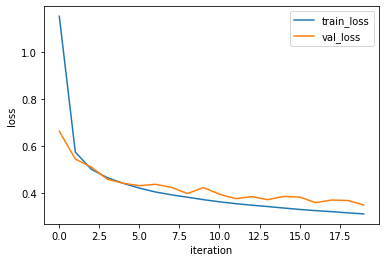

In [26]:
import matplotlib.pyplot as plt

plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [27]:
cn.score(x_val, y_val_endoded)

0.8810833333333333

In [29]:
conv1 = tf.keras.Sequential()
conv1.add(tf.keras.layers.Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))

In [30]:
# Pooling layers
conv1.add(tf.keras.layers.MaxPooling2D(2, 2)) 

# flatten the map
conv1.add(tf.keras.layers.Flatten())

# 완전 연결층
conv1.add(tf.keras.layers.Dense(100, activation='relu'))
conv1.add(tf.keras.layers.Dense(10, activation='softmax'))

conv1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               196100    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
_________________________________________________________________


In [33]:
conv1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = conv1.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 23s 16ms/step - loss: 0.4534 - accuracy: 0.8393 - val_loss: 0.3845 - val_accuracy: 0.8632
Epoch 2/20
1500/1500 [==============================] - 23s 16ms/step - loss: 0.3203 - accuracy: 0.8859 - val_loss: 0.3087 - val_accuracy: 0.8877
Epoch 3/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.2734 - accuracy: 0.9018 - val_loss: 0.2820 - val_accuracy: 0.9003
Epoch 4/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.2393 - accuracy: 0.9124 - val_loss: 0.2616 - val_accuracy: 0.9057
Epoch 5/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.2134 - accuracy: 0.9219 - val_loss: 0.2614 - val_accuracy: 0.9068
Epoch 6/20
1500/1500 [==============================] - 24s 16ms/step - loss: 0.1915 - accuracy: 0.9296 - val_loss: 0.2578 - val_accuracy: 0.9109
Epoch 7/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.1693 - accuracy: 0.9388 - val_loss: 0.2602 -

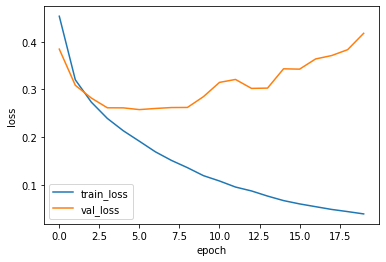

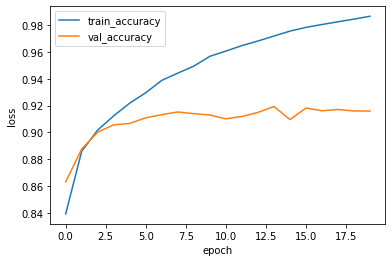

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [36]:
# with drop out
conv2 = tf.keras.Sequential()
conv2.add(tf.keras.layers.Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
conv2.add(tf.keras.layers.MaxPooling2D(2, 2))
conv2.add(tf.keras.layers.Flatten())
conv2.add(tf.keras.layers.Dropout(0.5))
conv2.add(tf.keras.layers.Dense(100, activation='relu'))
conv2.add(tf.keras.layers.Dense(10, activation='softmax'))

In [37]:
conv2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1960)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
________________________________________________

In [38]:
conv2.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy'])
history = conv2.fit(x_train, y_train_encoded, epochs=20, 
                    validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 37s 25ms/step - loss: 0.5154 - accuracy: 0.8163 - val_loss: 0.3543 - val_accuracy: 0.8763
Epoch 2/20
1500/1500 [==============================] - 37s 25ms/step - loss: 0.3797 - accuracy: 0.8628 - val_loss: 0.3156 - val_accuracy: 0.8901
Epoch 3/20
1500/1500 [==============================] - 37s 25ms/step - loss: 0.3400 - accuracy: 0.8768 - val_loss: 0.2888 - val_accuracy: 0.8972
Epoch 4/20
1500/1500 [==============================] - 39s 26ms/step - loss: 0.3082 - accuracy: 0.8868 - val_loss: 0.2862 - val_accuracy: 0.8938
Epoch 5/20
1500/1500 [==============================] - 37s 25ms/step - loss: 0.2906 - accuracy: 0.8933 - val_loss: 0.2635 - val_accuracy: 0.9043
Epoch 6/20
1500/1500 [==============================] - 35s 23ms/step - loss: 0.2774 - accuracy: 0.8976 - val_loss: 0.2541 - val_accuracy: 0.9072
Epoch 7/20
1500/1500 [==============================] - 38s 26ms/step - loss: 0.2636 - accuracy: 0.9028 - val_loss: 0.2475 -

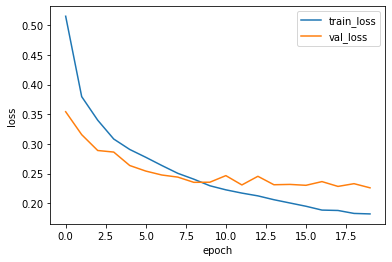

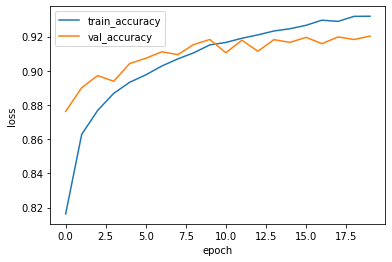

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()